# DistilBERT & LSTM
This code is utilizing DistilBERT and LSTM for stance detection. It firstly gets word embeddings using DistilBERT. Then, it gives these embeddings to bi-directional LSTM.

Since this architecture utilizes both DistilBERT and LSTM, it has lots of parameters. Due to memory limitations, we can only train this architecture with 9K training, 1K validation and 2K test data.

We conducted several experiments using this model. For instance, this code includes 0.5 dropout and 0.001 L2 regularization. We also remove them and observe their effects on the model and put the results to the report.

Additionally, currently this model has 64x3 dense layers. We also carry out experiments by making the model more complex, i.e. 128x64x32x3 dense layers

In [ ]:
!pip install ipython-autotime
%load_ext autotime
!pip install transformers
!pip install accelerate>=0.20.1
!pip install -U datasets
!pip install evaluate
!pip install --upgrade tensorflow

time: 30.6 s (started: 2023-12-14 22:10:35 +00:00)


In [ ]:
import tensorflow as tf
import torch
import re
import numpy as np
import pandas as pd
from transformers import Trainer, AutoTokenizer, AdamW, TrainingArguments
from datasets import Dataset, DatasetDict, ClassLabel
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader, TensorDataset, random_split
from evaluate import load
from sklearn.model_selection import train_test_split


time: 8.36 s (started: 2023-12-14 22:11:06 +00:00)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

time: 453 µs (started: 2023-12-14 22:11:14 +00:00)


In [ ]:
model_checkpoint = "distilbert-base-cased"
tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)

time: 390 ms (started: 2023-12-14 22:11:14 +00:00)


In [ ]:
def preprocess_data(data):
  cleaned_data = []
  for sent in data:
    sent = sent.lower()
    cleaned_sent = re.sub("@[A-Za-z0-9]+","", sent)  # Removing mentions like @abc.
    cleaned_sent = cleaned_sent.replace('#SemST','') #Removing SemEval tag.

    cleaned_data = np.append(cleaned_data,cleaned_sent)
  return cleaned_data

time: 756 µs (started: 2023-12-14 22:11:15 +00:00)


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
dataset_path = '/content/drive/MyDrive/CS533_Shared/project/dataset/dataset_merged.csv'
dataset_df = pd.read_csv(dataset_path)
# Convert column names to lowercase
dataset_df.columns = dataset_df.columns.str.lower()

Mounted at /content/drive
time: 3.73 s (started: 2023-12-14 22:11:15 +00:00)


In [ ]:
# splitting data into train and test
dataset_df, testset_df = train_test_split(dataset_df, test_size=0.1, random_state=42)

time: 6.33 ms (started: 2023-12-14 22:11:18 +00:00)


In [ ]:
import random

# Preprocesssing all tweets and stances
tweet_list = dataset_df['tweet'].tolist()
stance_list = dataset_df['stance'].tolist()

tweet_stance_pairs = list(zip(tweet_list, stance_list))
random.shuffle(tweet_stance_pairs)

shuffled_tweet_list, shuffled_stance_list = zip(*tweet_stance_pairs)

shuffled_tweet_list = list(shuffled_tweet_list)
shuffled_stance_list = list(shuffled_stance_list)

train_tweet_list = shuffled_tweet_list[:10000]
train_stance_list = shuffled_stance_list[:10000]

train_processed_tweet_list = preprocess_data(train_tweet_list)
train_processed_stance_list = preprocess_data(train_stance_list)

tweet_list = testset_df['tweet'].tolist()
stance_list = testset_df['stance'].tolist()

tweet_stance_pairs = list(zip(tweet_list, stance_list))
random.shuffle(tweet_stance_pairs)

shuffled_tweet_list, shuffled_stance_list = zip(*tweet_stance_pairs)

shuffled_tweet_list = list(shuffled_tweet_list)
shuffled_stance_list = list(shuffled_stance_list)

test_tweet_list = shuffled_tweet_list[:2000]
test_stance_list = shuffled_stance_list[:2000]

test_processed_tweet_list = preprocess_data(test_tweet_list)
test_processed_stance_list = preprocess_data(test_stance_list)

time: 35.4 s (started: 2023-12-14 22:11:18 +00:00)


In [ ]:
# Convert 'stance' column values to numeric values
def map_stance_to_numeric(stance):
    if stance == 'favor':
        return 1
    elif stance == 'against':
        return 2
    elif stance == 'none':
        return 0
    else:
        return None  # You can handle other cases as needed


train_stances = [map_stance_to_numeric(stance) for stance in train_processed_stance_list]
test_stances = [map_stance_to_numeric(stance) for stance in test_processed_stance_list]

time: 13.5 ms (started: 2023-12-14 22:11:54 +00:00)


In [ ]:
dataset_df = pd.DataFrame({'tweets': train_processed_tweet_list, 'labels': train_stances})
testset_df = pd.DataFrame({'tweets': test_processed_stance_list, 'labels': test_stances})

time: 10.2 ms (started: 2023-12-14 22:11:54 +00:00)


In [ ]:
print(dataset_df.info())
print("*"*30)
print(testset_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  10000 non-null  object
 1   labels  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  2000 non-null   object
 1   labels  2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None
time: 19.7 ms (started: 2023-12-14 22:11:54 +00:00)


In [ ]:
# Creating DatasetDict

# Creating a new DataFrame with only 'tweet' and 'stance_num' columns
train_and_validation_df = dataset_df[['tweets', 'labels']]
test_df = testset_df[['tweets', 'labels']]

# seperating training data into train and validation
train_df = train_and_validation_df.sample(frac=0.9, random_state=25)
validation_df = train_and_validation_df.drop(train_df.index)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

time: 6.98 ms (started: 2023-12-14 22:11:54 +00:00)


In [ ]:
train_x = train_df["tweets"].tolist()
train_y = train_df["labels"].tolist()

val_x = validation_df["tweets"].tolist()
val_y = validation_df["labels"].tolist()

test_x = test_df["tweets"].tolist()
test_y = test_df["labels"].tolist()

time: 1.4 ms (started: 2023-12-14 22:11:54 +00:00)


In [ ]:
print(f"Training X Length: {len(train_x)}")
print(f"Training Y Length: {len(train_y)}")

print(f"Validation X Length: {len(val_x)}")
print(f"Validation Y Length: {len(val_y)}")

print(f"Test X Length: {len(test_x)}")
print(f"Test Y Length: {len(test_y)}")

Training X Length: 9000
Training Y Length: 9000
Validation X Length: 1000
Validation Y Length: 1000
Test X Length: 2000
Test Y Length: 2000
time: 1.13 ms (started: 2023-12-14 22:11:54 +00:00)


In [ ]:
train_x_tokenized = tokenizer(train_x, return_tensors="pt", padding='max_length', truncation=True, max_length=119) # 119 is the max length of train & validation dataset. Found by experiment
val_x_tokenized = tokenizer(val_x, return_tensors="pt", padding='max_length', truncation=True, max_length=119)

time: 6.28 s (started: 2023-12-14 22:11:54 +00:00)


In [ ]:
print(type(train_x_tokenized))
print(train_x_tokenized)

<class 'transformers.tokenization_utils_base.BatchEncoding'>
{'input_ids': tensor([[ 101, 1142, 1110,  ...,    0,    0,    0],
        [ 101,  178, 5380,  ...,    0,    0,    0],
        [ 101, 1128, 9424,  ...,    0,    0,    0],
        ...,
        [ 101,  137,  168,  ...,    0,    0,    0],
        [ 101,  108, 1129,  ...,    0,    0,    0],
        [ 101, 1218,  178,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
time: 4.08 ms (started: 2023-12-14 22:12:00 +00:00)


In [ ]:
print(train_x_tokenized.input_ids.shape)
print(train_x_tokenized.attention_mask.shape)

torch.Size([9000, 119])
torch.Size([9000, 119])
time: 470 µs (started: 2023-12-14 22:12:00 +00:00)


In [ ]:
labels_tensor = torch.tensor(train_y)
dataset = TensorDataset(train_x_tokenized.input_ids, train_x_tokenized.attention_mask, labels_tensor)
loader = DataLoader(dataset, batch_size=32)

time: 2.38 ms (started: 2023-12-14 22:12:00 +00:00)


In [ ]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased', num_labels=3) # number of stance classes (e.g., 3 for favor, against, none)

time: 1.17 s (started: 2023-12-14 22:12:00 +00:00)


In [ ]:
embeddings = []
for batch in loader:
    batch_input_ids, batch_attention_mask = batch[0], batch[1]
    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_embeddings = outputs.last_hidden_state
        embeddings.append(batch_embeddings.numpy())

time: 7min 37s (started: 2023-12-14 22:12:01 +00:00)


In [ ]:
train_embeddings = np.concatenate(embeddings, axis=0)

time: 2.91 s (started: 2023-12-14 22:19:39 +00:00)


In [ ]:
val_x_tokenized['input_ids'].shape

torch.Size([1000, 119])

time: 2.71 ms (started: 2023-12-14 22:19:42 +00:00)


In [ ]:
val_labels_tensor = torch.tensor(val_y)
val_dataset = TensorDataset(val_x_tokenized.input_ids, val_x_tokenized.attention_mask, val_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)

time: 928 µs (started: 2023-12-14 22:19:42 +00:00)


In [ ]:
val_embeddings = []
for batch in val_loader:
    batch_input_ids, batch_attention_mask = batch[0], batch[1]
    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_embeddings = outputs.last_hidden_state
        val_embeddings.append(batch_embeddings.numpy())

time: 49.5 s (started: 2023-12-14 22:19:42 +00:00)


In [ ]:
val_embeddings = np.concatenate(val_embeddings, axis=0)

time: 321 ms (started: 2023-12-14 22:20:32 +00:00)


In [ ]:
# Define the amount of dropout and regularization strength
dropout_rate = 0.5
l2_strength = 0.001

time: 565 µs (started: 2023-12-14 22:20:32 +00:00)


In [ ]:
from tensorflow.keras.regularizers import l2

time: 2.25 ms (started: 2023-12-14 22:20:32 +00:00)


In [ ]:
bidirectional_model_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(train_embeddings.shape[1], train_embeddings.shape[2])),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=dropout_rate, recurrent_dropout=dropout_rate, kernel_regularizer=l2(l2_strength), recurrent_regularizer=l2(l2_strength))),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(l2_strength)),
    tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=l2(l2_strength))
])

time: 777 ms (started: 2023-12-14 22:20:32 +00:00)


In [ ]:
bidirectional_model_2.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=[
                           'accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.F1Score(name='f1_score')
                       ])

time: 26.8 ms (started: 2023-12-14 22:20:33 +00:00)


In [ ]:
from tensorflow.keras.utils import to_categorical

train_y_one_hot = to_categorical(train_y, num_classes=3)
val_y_one_hot = to_categorical(val_y, num_classes=3)

time: 3.33 ms (started: 2023-12-14 22:20:33 +00:00)


In [ ]:
print(train_embeddings.shape)
print(val_embeddings.shape)
print(np.array(train_y_one_hot).shape)
print(np.array(val_y_one_hot).shape)

(9000, 119, 768)
(1000, 119, 768)
(9000, 3)
(1000, 3)
time: 916 µs (started: 2023-12-14 22:20:33 +00:00)


In [ ]:
batch_size = 32
num_epochs = 20

train_history = bidirectional_model_2.fit(train_embeddings,
                                          np.array(train_y_one_hot),
                                          batch_size=batch_size,
                                          epochs=num_epochs,
                                          validation_data=(val_embeddings, np.array(val_y_one_hot)))

Epoch 1/20
282/282 [==============================] - 96s 320ms/step - loss: 1.4123 - accuracy: 0.4794 - precision: 0.4897 - recall: 0.2279 - f1_score: 0.3105 - val_loss: 1.0169 - val_accuracy: 0.4830 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.2815
Epoch 2/20
282/282 [==============================] - 98s 348ms/step - loss: 0.9836 - accuracy: 0.4832 - precision: 0.4996 - recall: 0.2021 - f1_score: 0.2744 - val_loss: 0.9109 - val_accuracy: 0.4880 - val_precision: 0.4929 - val_recall: 0.3140 - val_f1_score: 0.2186
Epoch 3/20
282/282 [==============================] - 89s 315ms/step - loss: 0.9325 - accuracy: 0.4941 - precision: 0.5137 - recall: 0.2577 - f1_score: 0.2656 - val_loss: 0.8771 - val_accuracy: 0.4880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.2186
Epoch 4/20
282/282 [==============================] - 89s 315ms/step - loss: 0.9124 - accuracy: 0.4873 - precision: 0.4920 - recall: 0.2361 - f1_score: 0.2625 - val_loss: 0.8803

In [ ]:
print(type(train_history))
print(train_history)

<class 'keras.src.callbacks.History'>
time: 1.08 ms (started: 2023-12-14 22:50:36 +00:00)


In [ ]:
train_history = train_history.history

time: 400 µs (started: 2023-12-14 22:50:36 +00:00)


Text(0, 0.5, 'Metrics')

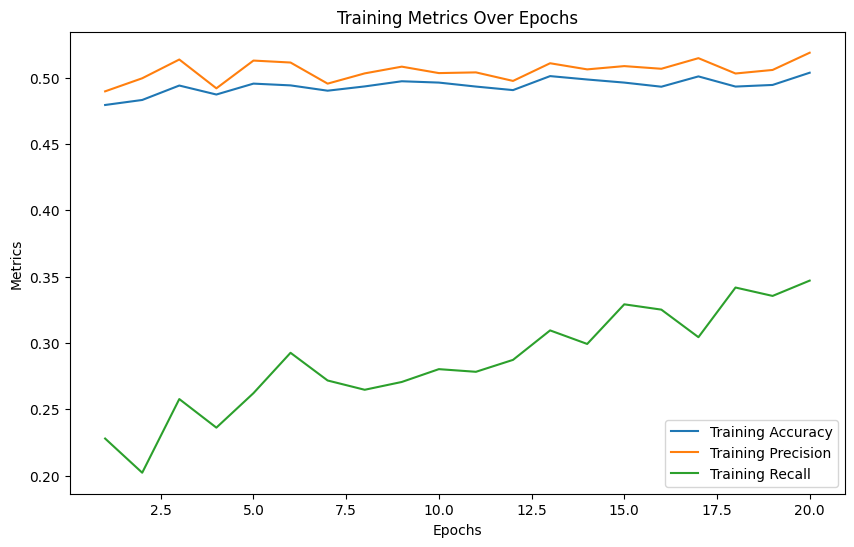

time: 398 ms (started: 2023-12-14 22:50:36 +00:00)


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_history['accuracy']) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_history['accuracy'], label='Training Accuracy')
plt.plot(epochs, train_history['precision'], label='Training Precision')
plt.plot(epochs, train_history['recall'], label='Training Recall')
plt.legend()

plt.title('Training Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')

### TESTING

In [ ]:
test_x_tokenized = tokenizer(test_x, return_tensors="pt", padding='max_length', truncation=True, max_length=119)

time: 209 ms (started: 2023-12-14 22:50:36 +00:00)


In [ ]:
test_labels_tensor = torch.tensor(test_y)
test_dataset = TensorDataset(test_x_tokenized.input_ids, test_x_tokenized.attention_mask, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

time: 1.14 ms (started: 2023-12-14 22:50:37 +00:00)


In [ ]:
test_embeddings = []
for batch in test_loader:
    batch_input_ids, batch_attention_mask = batch[0], batch[1]
    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_embeddings = outputs.last_hidden_state
        test_embeddings.append(batch_embeddings.numpy())

time: 1min 36s (started: 2023-12-14 22:50:37 +00:00)


In [ ]:
test_embeddings = np.concatenate(test_embeddings, axis=0)

time: 489 ms (started: 2023-12-14 22:52:13 +00:00)


In [ ]:
test_y_one_hot = to_categorical(test_y, num_classes=3)

test_history = bidirectional_model_2.evaluate(test_embeddings, np.array(test_y_one_hot))

63/63 [==============================] - 5s 75ms/step - loss: 1.1753 - accuracy: 0.5220 - precision: 0.8657 - recall: 0.5220 - f1_score: 0.2286
time: 6.47 s (started: 2023-12-14 22:52:14 +00:00)


In [ ]:
test_history

[1.1752735376358032,
 0.5220000147819519,
 0.8656716346740723,
 0.5220000147819519,
 array([0.        , 0.        , 0.68593955], dtype=float32)]

time: 3.83 ms (started: 2023-12-14 22:52:20 +00:00)
